# CMSE 492 – Diabetes Detection Project  
### HW08 – Preliminary Analysis Notebook  
**Author:** Nick Sleeper  
**Date:** November 2025  

---

### Overview  
This notebook fulfills **Part B** of HW08 and documents the preliminary exploratory analysis of the *Diabetes Health Indicators Dataset*.  
It covers:  

- **B1. Data Acquisition and Loading**  
- **B2. Initial Exploratory Data Analysis (EDA)**  
- **B3. Baseline Model Development**  

**Objectives:**  
1. Acquire and describe the dataset source and structure.  
2. Assess data quality, distributions, and relationships among key variables.  
3. Build a simple baseline classification model to predict diabetes diagnosis.  

All figures are saved to the `figures/` directory, and a 1 % data sample is stored in `data/processed/` for reproducibility.

In [55]:
# ========================================
# 1. Setup and Imports
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

pd.set_option("display.max_columns", None)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use("seaborn-v0_8-whitegrid")

## B1. Data Acquisition and Loading

The dataset contains **100,000 samples** and **31 variables** capturing demographic, lifestyle, and medical health indicators collected from a **synthetic population** modeled on the **CDC Behavioral Risk Factor Surveillance System (BRFSS)**.

**Goal:**  
Explore patterns associated with diabetes and establish a baseline classification model to predict whether an individual is diagnosed with diabetes (`diagnosed_diabetes` = 1) or not (`0`).

---

### Dataset Details

**Source:** [Kaggle – Diabetes Health Indicators Dataset](https://www.kaggle.com/datasets/mohankrishnathalla/diabetes-health-indicators-dataset)  
**Author:** Mohan Krishna Thalla (2023)  
**Nature:** Synthetic (privacy-safe, modeled on CDC BRFSS patterns)  
**Samples:** 100,000  
**Features:** 31  
**Target Variable:** `diagnosed_diabetes` (binary: 0 = No, 1 = Yes)  
**Missing Values:** None  

**Example Features:**
- Continuous: `age`, `bmi`, `glucose_fasting`, `hba1c`, `cholesterol_total`, `blood_pressure_systolic`
- Categorical: `gender`, `ethnicity`, `education_level`, `income_level`, `smoking_status`, `employment_status`

Dataset Shape: (100000, 31)


,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,7.9,7.9,0,0,0,30.5,0.89,134,78,68,239,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,6.5,8.7,0,0,0,23.1,0.80,129,76,67,116,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,10.0,8.1,1,0,0,22.2,0.81,115,73,74,213,66,99,36,118,195,5.07,7.51,44.7,Type 2,1


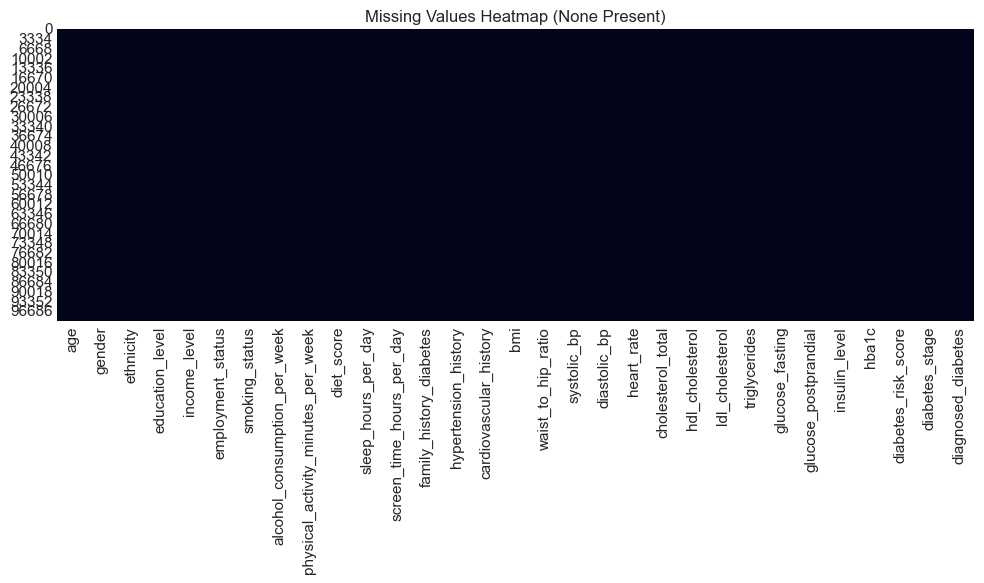

In [56]:
# ========================================
# Load Dataset
# ========================================
DATA_PATH = "/Users/nicksleeper/documents/FS25 CMSE-492/cmse492_project/data/raw/diabetes_dataset.csv"
FIG_PATH  = "/Users/nicksleeper/documents/FS25 CMSE-492/cmse492_project/figures/"

df = pd.read_csv(DATA_PATH)
print(f"Dataset Shape: {df.shape}")
display(df.head(3))

# Save 1% sample for reproducibility
df.sample(frac=0.01, random_state=RANDOM_STATE).to_csv(
    "/Users/nicksleeper/documents/FS25 CMSE-492/cmse492_project/data/processed/sample_processed.csv",
    index=False
)

# Missing values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap (None Present)")
plt.tight_layout()
plt.savefig(FIG_PATH + "missing_values_heatmap.png", dpi=300)
plt.show()

## 3. B2 – Initial Exploratory Data Analysis  

This section examines data quality, distributions, class balance, and feature relationships to understand patterns relevant to diabetes risk.  
Focus areas:  
- Summary statistics  
- Target balance and stage distribution  
- Feature relationships and correlations  

In [45]:
# Summary statistics for numerical features
summary_stats = df.describe().T
summary_stats["missing_values"] = df.isnull().sum()
summary_stats["dtype"] = df.dtypes
summary_stats.round(2)

,count,mean,std,min,25%,50%,75%,max,missing_values,dtype
age,100000.0,50.12,15.60,18.00,39.00,50.00,61.00,90.00,0,int64
alcohol_consumption_per_week,100000.0,2.00,1.42,0.00,1.00,2.00,3.00,10.00,0,int64
physical_activity_minutes_per_week,100000.0,118.91,84.41,0.00,57.00,100.00,160.00,833.00,0,int64
diet_score,100000.0,5.99,1.78,0.00,4.80,6.00,7.20,10.00,0,float64
sleep_hours_per_day,100000.0,7.00,1.09,3.00,6.30,7.00,7.70,10.00,0,float64
screen_time_hours_per_day,100000.0,6.00,2.47,0.50,4.30,6.00,7.70,16.80,0,float64
family_history_diabetes,100000.0,0.22,0.41,0.00,0.00,0.00,0.00,1.00,0,int64
hypertension_history,100000.0,0.25,0.43,0.00,0.00,0.00,1.00,1.00,0,int64
cardiovascular_history,100000.0,0.08,0.27,0.00,0.00,0.00,0.00,1.00,0,int64
bmi,100000.0,25.61,3.59,15.00,23.20,25.60,28.00,39.20,0,float64


### Target Class Distribution
The target variable (`diagnosed_diabetes`) shows a moderate class imbalance, with approximately 60% of samples diagnosed with diabetes (1) and 40% not diagnosed (0).  
This confirms the need to evaluate models using balanced metrics such as F1-score and recall rather than relying solely on accuracy.

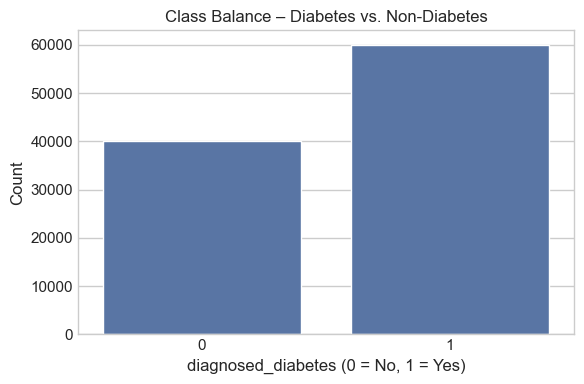

Class counts:
diagnosed_diabetes
1    0.59998
0    0.40002
Name: proportion, dtype: float64


In [46]:
plt.figure(figsize=(6,4))
sns.countplot(x="diagnosed_diabetes", data=df)
plt.title("Class Balance – Diabetes vs. Non-Diabetes")
plt.xlabel("diagnosed_diabetes (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../../figures/class_balance.png")
plt.show()

print("Class counts:")
print(df["diagnosed_diabetes"].value_counts(normalize=True))

### Diabetes Stage Distribution
Although not used directly in prediction (to prevent data leakage), the `diabetes_stage` variable provides useful context about the dataset’s structure.  
Most individuals fall into Type 2 or Pre-Diabetes categories, which aligns with real-world prevalence patterns.

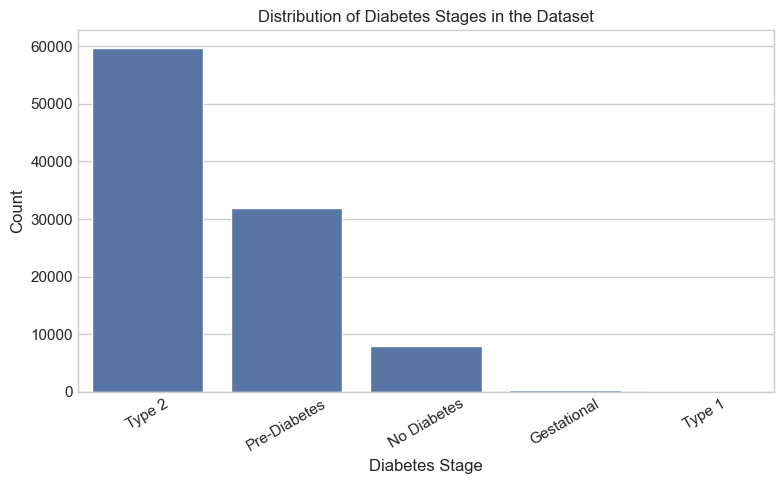

Diabetes Stage Counts:
diabetes_stage
Type 2          59774
Pre-Diabetes    31845
No Diabetes      7981
Gestational       278
Type 1            122
Name: count, dtype: int64

Diabetes Stage Percentages:
diabetes_stage
Type 2          59.77
Pre-Diabetes    31.85
No Diabetes      7.98
Gestational      0.28
Type 1           0.12
Name: proportion, dtype: float64


In [47]:
# Distribution of diabetes stages (Type 1, Type 2, No Diabetes, etc.)

plt.figure(figsize=(8,5))
sns.countplot(data=df, x="diabetes_stage", order=df["diabetes_stage"].value_counts().index)
plt.title("Distribution of Diabetes Stages in the Dataset")
plt.xlabel("Diabetes Stage")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("../../figures/diabetes_stage_distribution.png")
plt.show()

# Display counts and percentages
stage_counts = df["diabetes_stage"].value_counts()
stage_percent = df["diabetes_stage"].value_counts(normalize=True) * 100

print("Diabetes Stage Counts:")
print(stage_counts)
print("\nDiabetes Stage Percentages:")
print(stage_percent.round(2))

### 3.3 Glucose vs HbA1c Relationship  
Fasting glucose and HbA1c levels show a clear positive association, especially among diagnosed individuals.  
This validates dataset integrity and biological consistency.

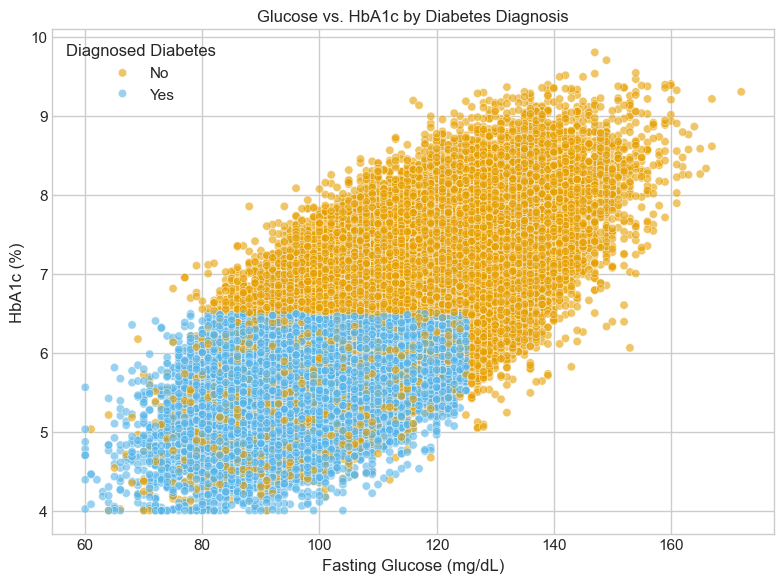

In [48]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, 
    x="glucose_fasting", 
    y="hba1c", 
    hue="diagnosed_diabetes", 
    palette=["#56B4E9", "#E69F00"], 
    alpha=0.6
)
plt.title("Glucose vs. HbA1c by Diabetes Diagnosis")
plt.xlabel("Fasting Glucose (mg/dL)")
plt.ylabel("HbA1c (%)")
plt.legend(title="Diagnosed Diabetes", labels=["No", "Yes"])
plt.tight_layout()
plt.savefig("/Users/nicksleeper/documents/FS25 CMSE-492/cmse492_project/figures/glucose_hba1c_scatter.png", dpi=300)
plt.show()

### 3.4 Body Mass Index (BMI) Distribution  
BMI follows a roughly normal distribution centered around 25–26, indicating a representative adult population.

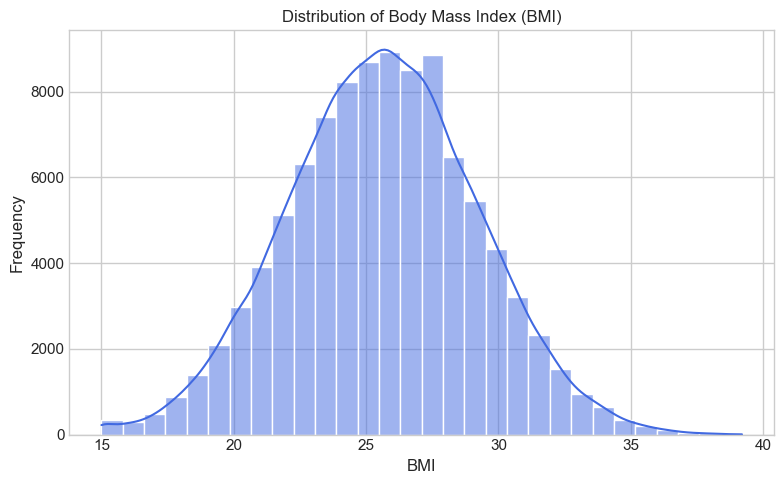

In [57]:
plt.figure(figsize=(8, 5))
sns.histplot(df["bmi"], kde=True, bins=30, color="royalblue")
plt.title("Distribution of Body Mass Index (BMI)")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("/Users/nicksleeper/documents/FS25 CMSE-492/cmse492_project/figures/bmi_distribution.png", dpi=300)
plt.show()

### 3.5 Age Distribution by Diabetes Status  
Age is one of the strongest demographic predictors of diabetes.  
This boxplot compares age distributions between individuals **with** and **without** a diabetes diagnosis.  
Those diagnosed tend to be older on average, which aligns with epidemiological expectations.

/var/folders/bl/lvtt_0f17y9bmbx8m8m66x3c0000gn/T/ipykernel_54562/1966367641.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="diagnosed_diabetes", y="age", palette=["#56B4E9", "#E69F00"])


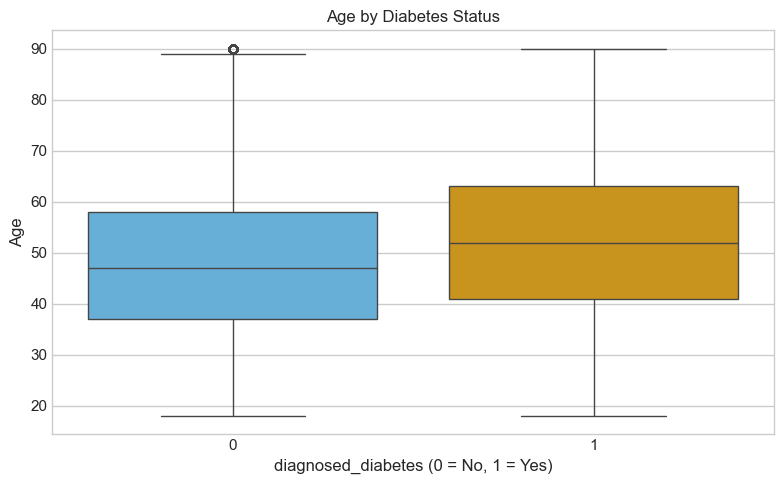

In [62]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="diagnosed_diabetes", y="age", palette=["#56B4E9", "#E69F00"])
plt.title("Age by Diabetes Status")
plt.xlabel("diagnosed_diabetes (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.tight_layout()
plt.savefig(FIG_PATH + "age_by_diabetes.png", dpi=300)
plt.show()

### 3.6 Correlation with Target  
The strongest correlations with diabetes diagnosis are observed for `hba1c`, `glucose_postprandial`, and `glucose_fasting`.  
Lifestyle features show weaker associations.

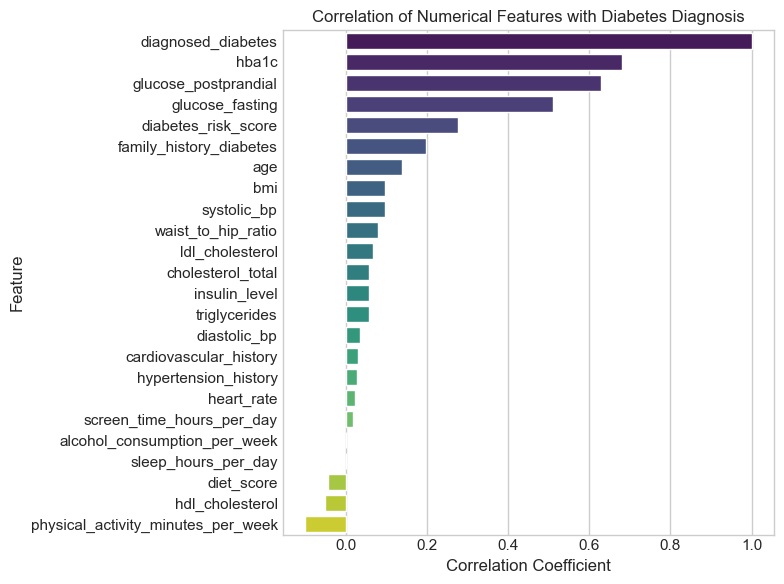

In [58]:
corr_target = df.corr(numeric_only=True)["diagnosed_diabetes"].sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=corr_target.values, y=corr_target.index, palette="viridis", hue=corr_target.index, legend=False)
plt.title("Correlation of Numerical Features with Diabetes Diagnosis")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(FIG_PATH + "correlation_with_target.png", dpi=300)
plt.show()

### 3.7 Overall Correlation Matrix  
The heatmap below visualizes pairwise relationships between numerical features, confirming expected medical patterns (e.g., BP, lipids, glucose).

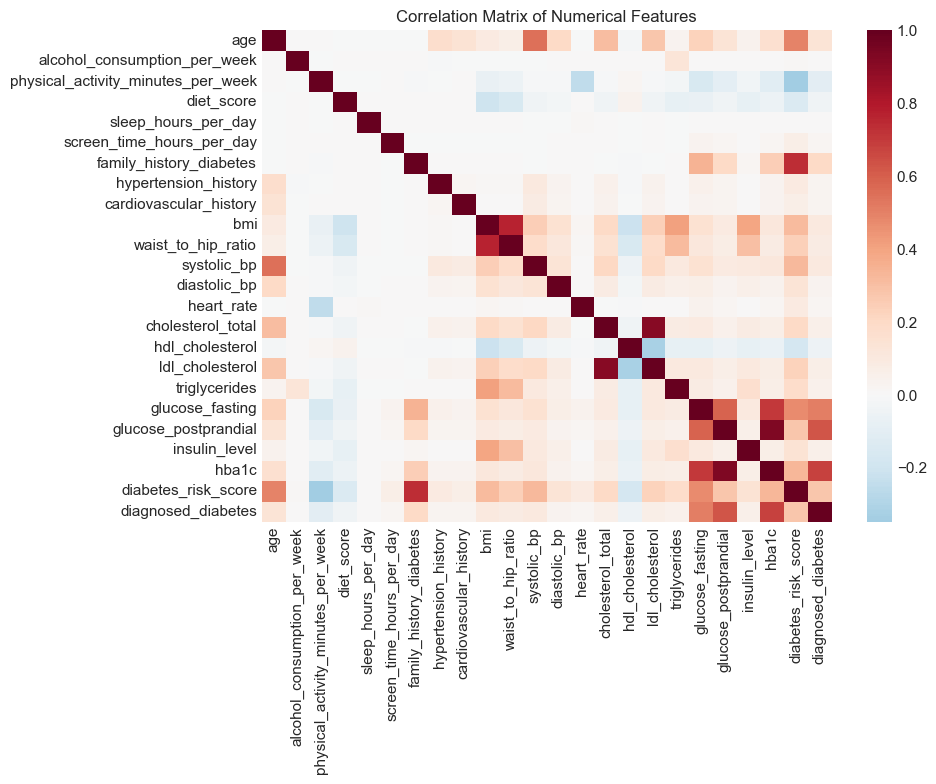

In [61]:
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="RdBu_r", center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.savefig(FIG_PATH + "correlation_matrix.png", dpi=300)
plt.show()

## 4. B3 – Baseline Model  

Two models are tested as initial benchmarks:  
1. **Majority-Class Predictor** (always predicts the most common class).  
2. **Logistic Regression Baseline** (uses demographic and clinical features).  

To avoid data leakage, derived features `diabetes_stage` and `diabetes_risk_score` are excluded from training.

In [59]:
target = "diagnosed_diabetes"
drop_cols = ["diabetes_stage", "diabetes_risk_score"]
X = df.drop(columns=[target] + drop_cols)
y = df[target]

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if X[c].dtype != "object"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_STATE, stratify=y)

# Majority baseline
majority_class = y_train.mode()[0]
majority_pred = np.full_like(y_test, majority_class)
print(f"Majority-Class Baseline → Accuracy: {accuracy_score(y_test, majority_pred):.3f}, "
      f"F1: {f1_score(y_test, majority_pred):.3f}")

# Logistic regression baseline
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

model = Pipeline([
    ("preprocessor", preprocess),
    ("classifier", LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)
preds = model.predict(X_test)

print("\nLogistic Regression Baseline Results")
print(f"Accuracy: {accuracy_score(y_test, preds):.3f}")
print(f"F1 Score: {f1_score(y_test, preds):.3f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds))

Majority-Class Baseline → Accuracy: 0.600, F1: 0.750

Logistic Regression Baseline Results
Accuracy: 0.861
F1 Score: 0.885

Confusion Matrix:
 [[ 6475  1525]
 [ 1257 10743]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82      8000
           1       0.88      0.90      0.89     12000

    accuracy                           0.86     20000
   macro avg       0.86      0.85      0.85     20000
weighted avg       0.86      0.86      0.86     20000



## 5. Results Summary  

| Model | Accuracy | F1 Score |  
|:--|:--:|:--:|  
| Majority Baseline | 0.600 | 0.750 |  
| Logistic Regression | 0.861 | 0.885 |  

The logistic regression model significantly outperforms the naive baseline, demonstrating that demographic and clinical features contain predictive signal.  
The confusion matrix shows balanced recall for both classes, indicating strong initial model performance.

## 6. Project Timeline 

The timeline below illustrates planned progress from Week 10 to Week 15 of the semester, covering EDA, model development, evaluation, and presentation.

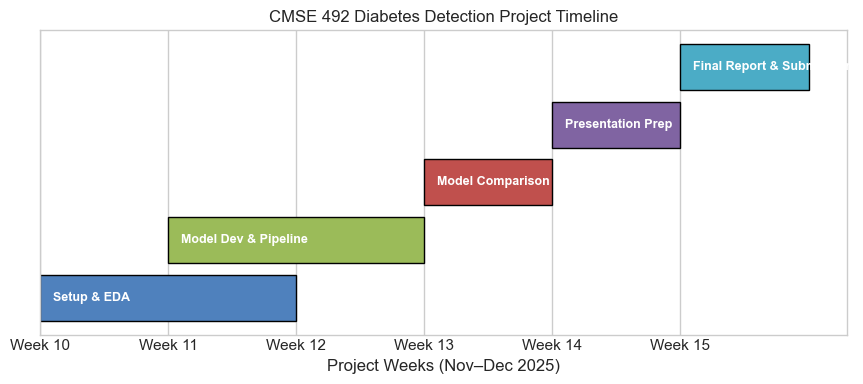

In [60]:
tasks = [
    ("Setup & EDA", 10, 11),
    ("Model Dev & Pipeline", 11, 12),
    ("Model Comparison", 13, 13),
    ("Presentation Prep", 14, 14),
    ("Final Report & Submission", 15, 15)
]

colors = ["#4F81BD", "#9BBB59", "#C0504D", "#8064A2", "#4BACC6"]

plt.figure(figsize=(9,4))
for i, (task, start, end) in enumerate(tasks):
    plt.barh(i, end - start + 1, left=start, color=colors[i], edgecolor="black")
    plt.text(start + 0.1, i, task, va="center", ha="left",
             color="white", fontsize=9, fontweight="bold")

plt.yticks([])
plt.xticks(range(10,16), [f"Week {w}" for w in range(10,16)])
plt.xlabel("Project Weeks (Nov–Dec 2025)")
plt.title("CMSE 492 Diabetes Detection Project Timeline")
plt.tight_layout()
plt.savefig(FIG_PATH + "gantt_chart.png", dpi=300)
plt.show()